# Quick start guide to QSPRpred

Welcome to the quick start guide to QSPRpred.
Here we will cover the fundamentals of using QSPRpred.
We will show you how to create a dataset, train a Quantitative Structure-Property Relationship (QSPR) model, and make predictions.
This tutorial is not meant as an introduction to QSPR modelling and assumes a base level of knowledge on the topic. If you are interested in getting started with QSPR modelling, you could have a look at these [TeachOpenCADD tutorials](https://projects.volkamerlab.org/teachopencadd/).

While this tutorial provides a good starting point, there are many additional features that are not covered here.
For more in-depth information, you can explore [the other tutorials](README.md) and consult the [documentation](https://cddleiden.github.io/QSPRpred/docs/).


## Creating a dataset
In this tutorial, we will work with a dataset containing bioactivity data for various compounds tested on the human adenosine A2A receptor. The data was collected from [Papyrus](https://github.com/OlivierBeq/Papyrus-scripts), a curated bioactivity database. The tutorial data is available through [OneDrive](https://1drv.ms/u/s!AtzWqu0inkjX3QRxXOkTFNv7IV7u?e=PPj0O2) (just unzip and place the two datasets `A2A_LIGANDS.tsv` and `AR_LIGANDS.tsv` in the `tutorial_data` folder) or recreate the dataset yourself by running `tutorial_data/create_tutorial_data.py`.

To start we will load the tsv file containing the dataset.

In [11]:
import pandas as pd

df = pd.read_csv('tutorial_data/A2A_LIGANDS.tsv', sep='\t')

df.head()

,SMILES,pchembl_value_Mean,Year
0,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,8.68,2008.0
1,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2c1cc1CCCC...,4.82,2010.0
2,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,5.65,2009.0
3,CNC(=O)C12CC1C(n1cnc3c1nc(C#CCCCCC(=O)OC)nc3NC...,5.45,2009.0
4,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,5.20,2019.0


Now we will create a `QSPRDataset` object from the data.
This object contains the data and metadata for the dataset, and can be used to train a QSPR model. Note that the modelling task (regression) and the target property (pchembl_value_Mean) are specified when creating the dataset.
We set a random seed to ensure reproducibility, which is used for any random processes in the data preparation, such as splitting the data into training and test sets and shuffling of the dataframe.

In [12]:
from qsprpred.data import QSPRDataset
import os

os.makedirs("tutorial_output/data", exist_ok=True)

dataset = QSPRDataset(
    df=df,
    store_dir="tutorial_output/data",
    name="QuickStartDataset",
    target_props=[{"name": "pchembl_value_Mean", "task": "REGRESSION"}],
    random_state=42
)

dataset.getDF()

,SMILES,pchembl_value_Mean,Year,QSPRID
QSPRID,,,,
QuickStartDataset_0000,Cc1nn(-c2cc(NC(=O)CCN(C)C)nc(-c3ccc(C)o3)n2)c(...,8.68,2008.0,QuickStartDataset_0000
QuickStartDataset_0001,Nc1c(C(=O)Nc2ccc([N+](=O)[O-])cc2)sc2c1cc1CCCC...,4.82,2010.0,QuickStartDataset_0001
QuickStartDataset_0002,O=C(Nc1nc2ncccc2n2c(=O)n(-c3ccccc3)nc12)c1ccccc1,5.65,2009.0,QuickStartDataset_0002
QuickStartDataset_0003,CNC(=O)C12CC1C(n1cnc3c1nc(C#CCCCCC(=O)OC)nc3NC...,5.45,2009.0,QuickStartDataset_0003
QuickStartDataset_0004,CCCn1c(=O)c2c(nc3cc(OC)ccn32)n(CCCNC(=O)c2ccc(...,5.20,2019.0,QuickStartDataset_0004
...,...,...,...,...
QuickStartDataset_4077,CNc1ncc(C(=O)NCc2ccc(OC)cc2)c2nc(-c3ccco3)nn12,7.09,2018.0,QuickStartDataset_4077
QuickStartDataset_4078,Nc1nc(-c2ccco2)c2ncn(C(=O)NCCc3ccccc3)c2n1,8.22,2008.0,QuickStartDataset_4078
QuickStartDataset_4079,Nc1nc(Nc2ccc(F)cc2)nc(CSc2nnc(N)s2)n1,4.89,2010.0,QuickStartDataset_4079


After creating the dataset, we need to prepare it for model training.
To do this we need to specifiy what molecule descriptors to calculate as features for the model.
Here we will calculate Morgan fingerprints.
We will also specify what type of split to use to split the data into training and test sets.
In this example we will use a random split with 80% of the data for training and 20% for testing.

Finally, we will save the dataset so we can re-load it later for reproducibility and good data management purposes.
This also means we can skip the data preparation step next time we want to train a model on this dataset.

In [13]:
from qsprpred.data import RandomSplit
from qsprpred.data.descriptors.sets import FingerprintSet
from qsprpred.data.descriptors.calculators import MoleculeDescriptorsCalculator

# define the feature calculator to calculate Morgan fingerprints
feature_calculator = MoleculeDescriptorsCalculator(
    desc_sets=[FingerprintSet(fingerprint_type="MorganFP", radius=3, nBits=2048)]
)

# Specifiy random split for creating the train (80%) and test set (20%)
rand_split = RandomSplit(test_fraction=0.2, dataset=dataset)

# calculate compound features and split dataset into train and test
dataset.prepareDataset(
    split=rand_split,
    feature_calculators=[feature_calculator],
)

print(f"Number of samples in train set: {len(dataset.y)}")
print(f"Number of samples in test set: {len(dataset.y_ind)}")



dataset.save()

Number of samples in train set: 3265
Number of samples in test set: 817


## Training a model

Having successfully created a dataset, we can now train a QSAR model.
Here we will train a model using the `KNeighborsRegressor` estimator from scikit-learn.

To do this we first need to create a `QSPRModel` object, which contains the estimator and metadata for the model.
We will use the `SklearnModel` subclass, which is a wrapper for scikit-learn models.

In this example: the training of our model is divided into three steps:
* cross-validation: estimate the performance of the model on the training set
* test set evaluation: estimate the performance of the model on the test set
* full training: train the model on the full dataset, to be used for making predictions

In [14]:
from qsprpred.models import SklearnModel
from sklearn.neighbors import KNeighborsRegressor
from qsprpred.models.assessment_methods import CrossValAssessor, TestSetAssessor

os.makedirs("tutorial_output/models", exist_ok=True)

# This is an SKlearn model, so we will initialize it with the SklearnModel class
model = SklearnModel(
    base_dir='tutorial_output/models',
    data=dataset,
    alg=KNeighborsRegressor,
    name='QuickStartModel'
)

# We can now assess the model performance on the training set using cross validation
CrossValAssessor('r2')(model)

# and on the test set
TestSetAssessor('r2')(model)

# Finally, we need to fit the model on the complete dataset if we want to use it further
# This will save the fitted model and metadata to disk
model.fitAttached()

# We can optionally save the model and metadata to disk explicitly as well
model.save()

/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

'/zfsdata/data/helle/01_MainProjects/03_QSPRPred/Scripts/QSPRpred/tutorials/tutorial_output/models/QuickStartModel/QuickStartModel_meta.json'

The results can be easily visualized using the `CorrelationPlot` class

QuickStartModel


/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/helle/.conda/envs/qsprpred/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd

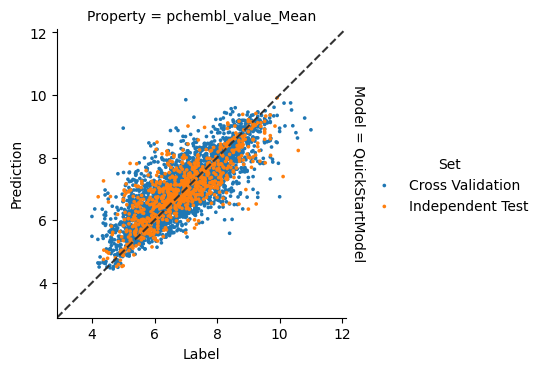

             Model              Fold            Property        R2      RMSE  \
0  QuickStartModel               0.0  pchembl_value_Mean  0.639693  0.483598   
1  QuickStartModel               1.0  pchembl_value_Mean  0.654970  0.477340   
2  QuickStartModel               2.0  pchembl_value_Mean  0.664356  0.441889   
3  QuickStartModel               3.0  pchembl_value_Mean  0.654299  0.447052   
4  QuickStartModel               4.0  pchembl_value_Mean  0.568736  0.591593   
5  QuickStartModel  Independent Test  pchembl_value_Mean  0.629332  0.510828   

                Set  
0  Cross Validation  
1  Cross Validation  
2  Cross Validation  
3  Cross Validation  
4  Cross Validation  
5  Independent Test  


<Figure size 640x480 with 0 Axes>

In [15]:
from qsprpred.plotting.regression import CorrelationPlot

plot = CorrelationPlot([model])
axes, summary = plot.make(save=False, show=True)
print(summary)

## Making predictions

After training the model, we can use it to make predictions on new compounds.

In [17]:
smiles_list = ["c1(cc(c(O)cc1)O)CCN", "CC(=O)OC1=CC=CC=C1C(=O)O",
               "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"]

model.predictMols(smiles_list)

array([[6.572],
       [5.202],
       [6.465]])

## Reloading

The `QSPRDataset` and `QSPRModel` objects can be easily reloaded from disk using the `fromFile` methods as long as they had been save before.

In [18]:
dataset = QSPRDataset.fromFile(
    './tutorial_output/data/QuickStartDataset/QuickStartDataset_meta.json')
model = SklearnModel.fromFile(
    './tutorial_output/models/QuickStartModel/QuickStartModel_meta.json')

## What's next?

This tutorial has covered the basics of using QSPRpred. If you are new to QSPRpred and interested in learning more, we recommend you check out the [data representation tutorial](basics/data/data_representation.ipynb) next.
If you are looking for a specific topic, you can have a look in the [list of tutorials](table_of_contents.md).